## Kaggle Titanic

### Serious EDA (EDA1/wip)
Branched from master to do additional and more comprehensive EDA.

In [1]:
%%bash
git branch

  CV_check
* EDA1/wip
  cost1/feat1/wip
  cost1/feat2/wip
  cost1/wip
  feat1/score1/wip
  feat1/wip
  feat2/score1/wip
  feat2/wip
  feat3/wip
  feat4/wip
  feat5/wip
  feat6/wip
  master


In [35]:
%%bash
git add 'Titanic.ipynb'
git commit -m 'Finised on EDA part of the workbook '
git push --set-upstream origin EDA1/wip

[EDA1/wip 41eb6cb] Finised embarked feature analysis, fill Nan with "S"
 1 file changed, 310 insertions(+), 224 deletions(-)
Branch EDA1/wip set up to track remote branch EDA1/wip from origin.


To github.com:Theerit/Kaggle_Titanic.git
   1ecd7d8..41eb6cb  EDA1/wip -> EDA1/wip


As usual, import all neccasary stuff into the notebook

In [1]:
%matplotlib inline 
import requests 
import StringIO
import zipfile
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 

# If this module is not already installed, you may need to install it. 
# You can do this by typing 'pip install seaborn' in the command line
import seaborn as sns 

import sklearn.model_selection

/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


First, I will start by loading the data in panda dataframe and do some EDA.

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
#Concate train and test to avoid mismatch features in the testing phase
train_objs_num = len(train)
dataset = pd.concat(objs=[train, test], axis=0)
#dataset = pd.get_dummies(dataset)
#train = dataset.copy(dataset[:train_objs_num])
train = dataset[:train_objs_num].copy()
#test = dataset.copy(dataset[train_objs_num:])
test = dataset[train_objs_num:].copy()
print(train.shape)

(891, 12)


Take a peek look at raw data table.

In [3]:
train.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


It appears that the test data has no label(answer class) and seems to serve submission function. Cross validation and model evaluation will be done based on the data provided in Train.csv file only. Next, split dataframe into X and Y dataframe where X store the data while Y store the label.

In [4]:
X = train.copy()
#X = X.drop('Survived',axis=1)
X_plot = train.copy()
X = X.drop('PassengerId',axis=1)  # Shouldn't relate to survival chance
Y = pd.DataFrame(train['Survived'])

In [5]:
Y[Y['Survived']==1].count()

Survived    342
dtype: int64

### Label Class Distribution
Lets take a look at class (Survived) distribution, the distribution is slightly skew where more passengers didn't survive.

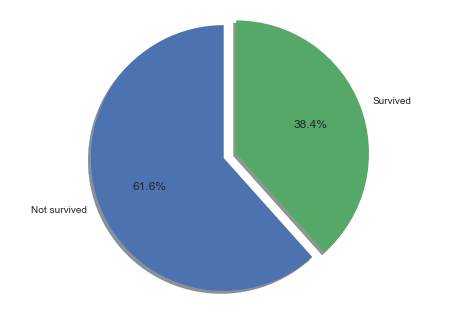

In [6]:
fig1, ax1 = plt.subplots()
explode = (0.05,0.05)
sizes = [Y[Y['Survived']==0].count(),Y[Y['Survived']==1].count()]
ax1.pie(sizes, explode = explode,labels=['Not survived','Survived'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Sanitizing data, finding all NaN data in X

In [7]:
X.isnull().any()

Age          True
Cabin        True
Embarked     True
Fare        False
Name        False
Parch       False
Pclass      False
Sex         False
SibSp       False
Survived    False
Ticket      False
dtype: bool

### Start with categorical feature : Sex

From result below, female tend to survive higher

In [8]:
X_plot.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0.0          81
        1.0         233
male    0.0         468
        1.0         109
Name: Survived, dtype: int64

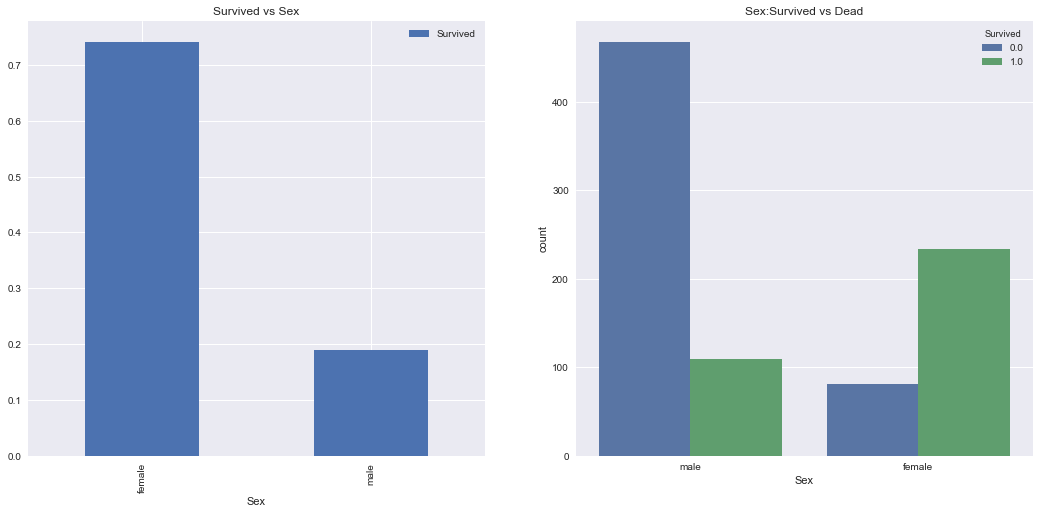

In [9]:
f,ax=plt.subplots(1,2,figsize=(18,8))
X_plot[['Sex','Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot('Sex',hue='Survived',data=X_plot,ax=ax[1])
ax[1].set_title('Sex:Survived vs Dead')
plt.show()

### Categorical feature: PClass

This one acts like ordinal feature rather than simple qualitative feature.

Results suggest that 
    - First Class passengers is more likely to survive. (The only class that has higher chance of surviving)
    - Majority of passengers is from the third class.
    - Third class passengers are more likely to die, second class chances are equal.

In [10]:
pd.crosstab(X_plot.Pclass,X_plot.Survived,margins=True).style.background_gradient(cmap='summer_r')

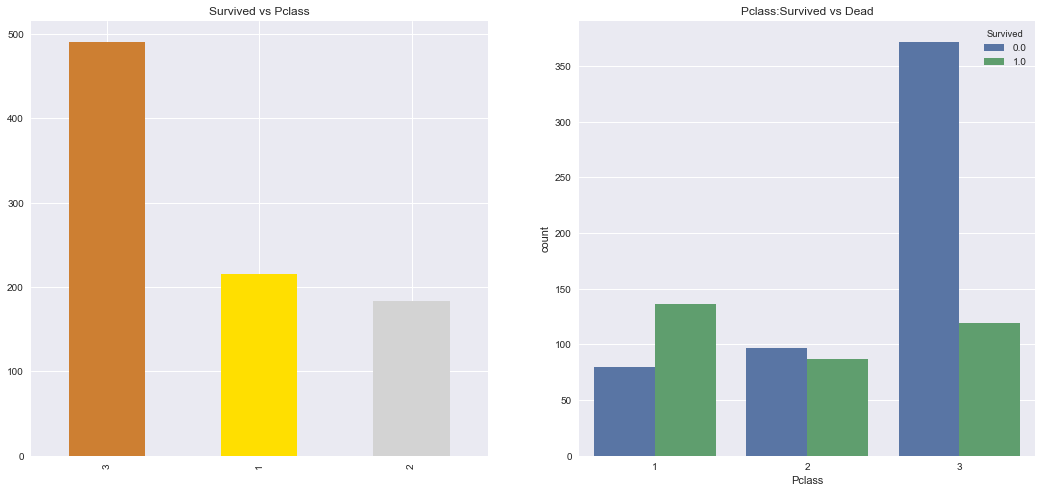

In [11]:
f,ax=plt.subplots(1,2,figsize=(18,8))
X_plot['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Survived vs Pclass')
sns.countplot('Pclass',hue='Survived',data=X_plot,ax=ax[1])
ax[1].set_title('Pclass:Survived vs Dead')
plt.show()

### Categorical feature: PClass vs Sex

- For female in third class, their chance are lot worse than female in class 1,2
- For male in all clases, they are more likely to not survived.

In [12]:
pd.crosstab([X_plot.Sex,X_plot.Survived],X_plot.Pclass,margins=True).style.background_gradient(cmap='summer_r')

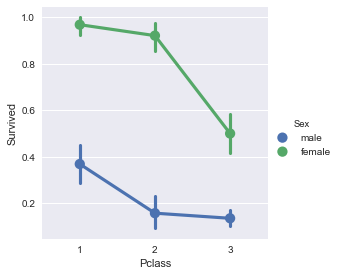

In [13]:
sns.factorplot('Pclass','Survived',data=X_plot,hue="Sex")
plt.show()

### Numerical feature: Age

Check on lower,upper bound to get more understanding. From violin plots
- Two humps on age probably indicate that there are high chance of surviving if you are adults(not old)/really chidren(not teens)
- Age distribution in people from first class who survived is pretty smooth (one hump)
- First class demagrophic is of higher age
- Male has larger age distribution

In [14]:
print('Oldest passenger:',X_plot.Age.max(),'Years')
print('Youngest passenger:',X_plot.Age.min(),'Years')
print('Average:',X_plot.Age.mean(),'Years')

('Oldest passenger:', 80.0, 'Years')
('Youngest passenger:', 0.41999999999999998, 'Years')
('Average:', 29.69911764705882, 'Years')


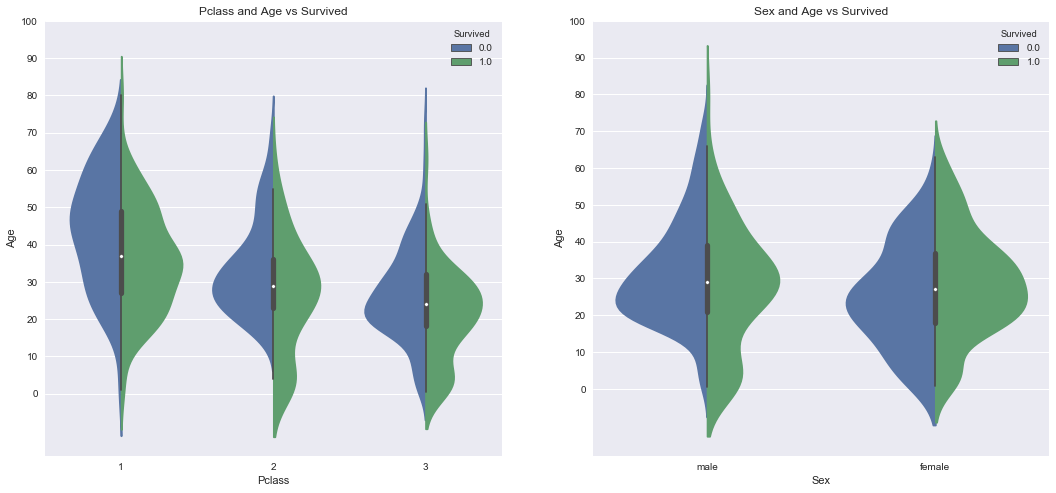

In [15]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot("Pclass","Age", hue="Survived", data=X_plot,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot("Sex","Age", hue="Survived", data=X_plot,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

### Extract age from name

Extract some useful information from name, to convert the information to age. Take a look at mean age then assign person who doesn't have age (Nan value in Age) the mean value according to their initials

In [16]:
X_plot['Initial']=0
for i in X_plot:
    X_plot['Initial']=X_plot.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
#X_plot['Initial'].value_counts()

#Change data in X also (since its the real training data)
X['Initial']=0
for i in X:
    X['Initial']=X.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

pd.crosstab(X_plot.Initial,X_plot.Sex).T.style.background_gradient(cmap='summer_r')

/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  app.launch_new_instance()
/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


Replace some of the initials with appropriate initials (for more accurate age assign)

In [17]:
X['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [18]:
# Take a lot at mean age of Mr vs Miss Master
print('Mean age of Mr:',X_plot[X_plot['Initial']=="Mr"]['Age'].mean())
print('Mean age of Miss:',X_plot[X_plot['Initial']=="Miss"]['Age'].mean())
print('Mean age of Mrs:',X_plot[X_plot['Initial']=="Mrs"]['Age'].mean())
print('Mean age of Master:',X_plot[X_plot['Initial']=="Master"]['Age'].mean())
others = ['Mr','Miss','Mrs','Master']
print('Mean age of others:',X_plot[~X_plot['Initial'].isin(others)]['Age'].mean())

('Mean age of Mr:', 32.368090452261306)
('Mean age of Miss:', 21.773972602739725)
('Mean age of Mrs:', 35.898148148148145)
('Mean age of Master:', 4.5741666666666667)
('Mean age of others:', 42.384615384615387)


In [19]:
X['Age'][(X['Initial']=='Mr') & (X['Age'].isnull())] = X[X['Initial']=='Mr']['Age'].mean()
X['Age'][(X['Initial']=='Miss') & (X['Age'].isnull())] = X[X['Initial']=='Miss']['Age'].mean()
X['Age'][(X['Initial']=='Mrs') & (X['Age'].isnull())] = X[X['Initial']=='Mrs']['Age'].mean()
X['Age'][(X['Initial']=='Master') & (X['Age'].isnull())] = X[X['Initial']=='Master']['Age'].mean()
X['Age'][(X['Initial']=='other') & (X['Age'].isnull())] = X[X['Initial']=='other']['Age'].mean()

/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
X['Age'].isnull().any()

False

### Numerical Feature: Age

- Age survival distribution shows 2 hump (clear)
- Being female and children increases change of surviving

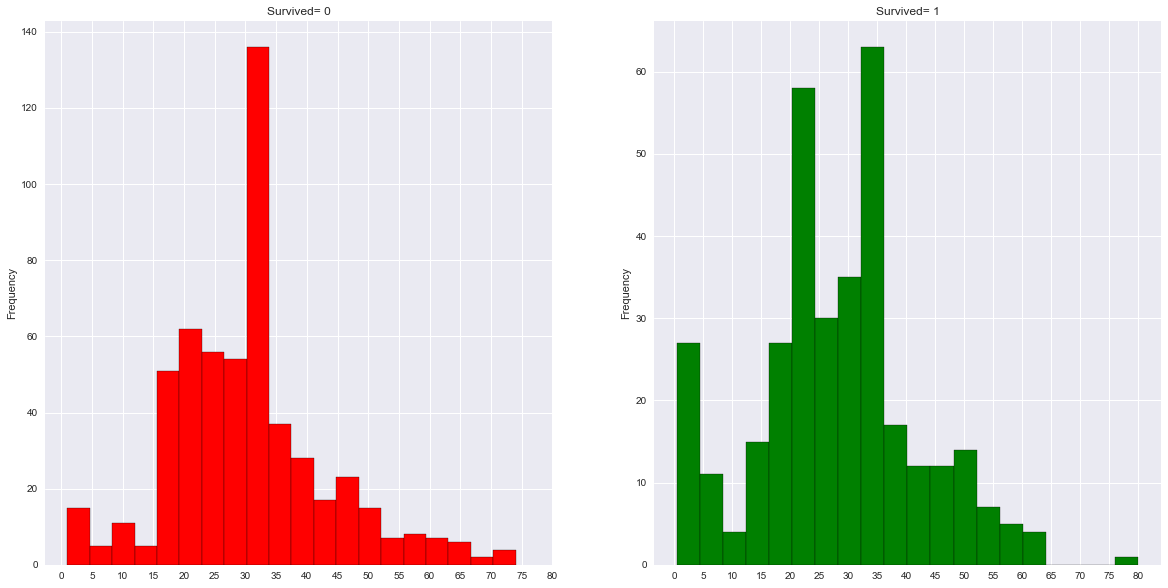

In [21]:
f,ax=plt.subplots(1,2,figsize=(20,10))
X[X['Survived']==0].Age.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='red')
ax[0].set_title('Survived= 0')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
X[X['Survived']==1].Age.plot.hist(ax=ax[1],color='green',bins=20,edgecolor='black')
ax[1].set_title('Survived= 1')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()

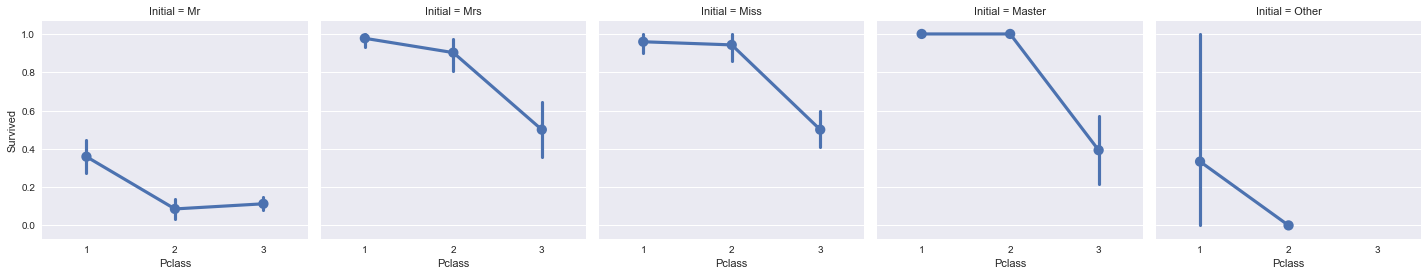

In [22]:
sns.factorplot('Pclass','Survived',col='Initial',data=X)
plt.show()

### Categorical variable: Embarked

#### Fill the Nan embarked value with S (Mode)
- Majority of passenger is from S
- Embark on C increase your chance of survival
- Embark on S has lowest chance of survival
- Lots of male embark on S which could lead to low survival rate from people who embark on  (male has lower chance)
- Lots of class3 people embark on S (could also support the low chance of survival)
- More first class people embark on C (could lead to somewhat high chance of survival on C)

In [23]:
pd.crosstab(X_plot.Embarked,X_plot.Survived,margins=True).style.background_gradient(cmap='summer_r')

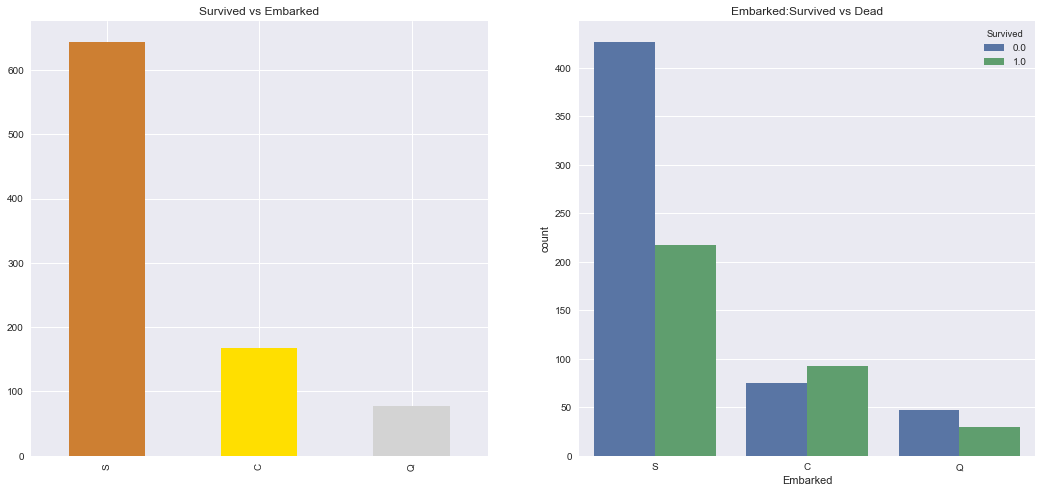

In [24]:
f,ax=plt.subplots(1,2,figsize=(18,8))
X_plot['Embarked'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Survived vs Embarked')
sns.countplot('Embarked',hue='Survived',data=X_plot,ax=ax[1])
ax[1].set_title('Embarked:Survived vs Dead')
plt.show()

Take a look at embark vs other categorical attributes.

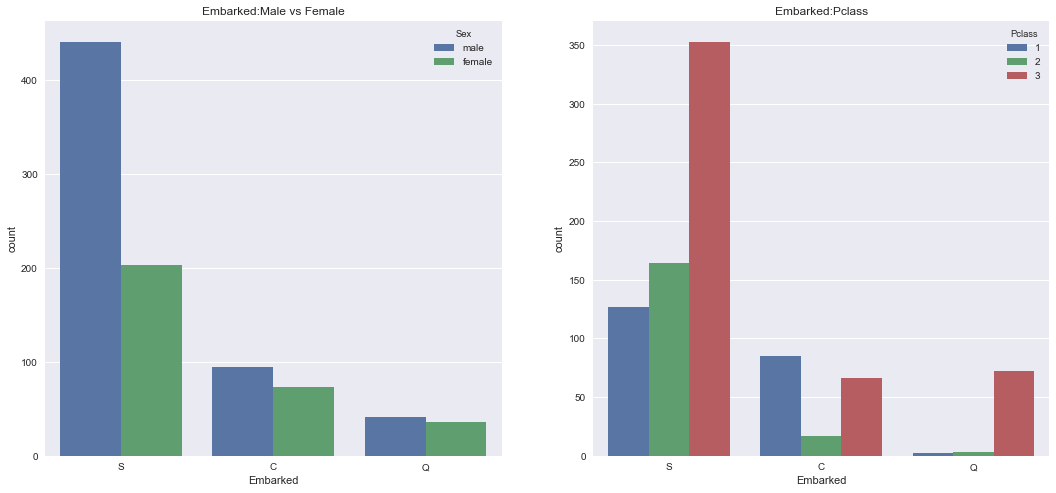

In [25]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.countplot('Embarked',hue='Sex',data=X_plot,ax=ax[0])
ax[0].set_title('Embarked:Male vs Female')

sns.countplot('Embarked',hue='Pclass',data=X_plot,ax=ax[1])
ax[1].set_title('Embarked:Pclass')

plt.show()

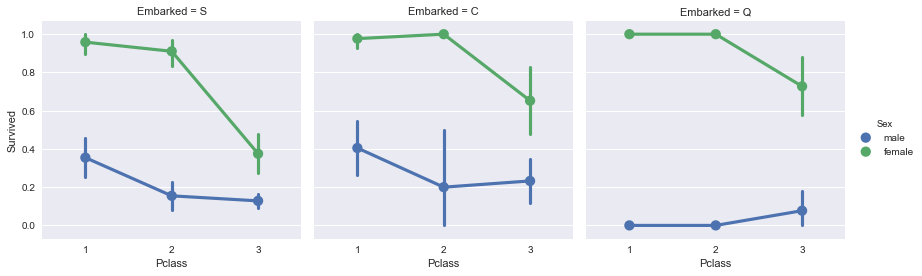

In [26]:
sns.factorplot('Pclass','Survived',hue='Sex',col='Embarked',data=X_plot)
plt.show()

In [34]:
X['Embarked'].fillna("S",inplace=True)
X['Embarked'].isnull().any()

False

### Categorical Feature: Sibsip

- Majority of passengers don't have any siblings
- Those who have one sibling tend to have higher chance of surviving
- more than one siblings decrease chance of surviving
- Large siblings family is in class 3 (small chance of surviving)

In [39]:
pd.crosstab(X_plot.SibSp,X_plot.Survived,margins=True).style.background_gradient(cmap='summer_r')

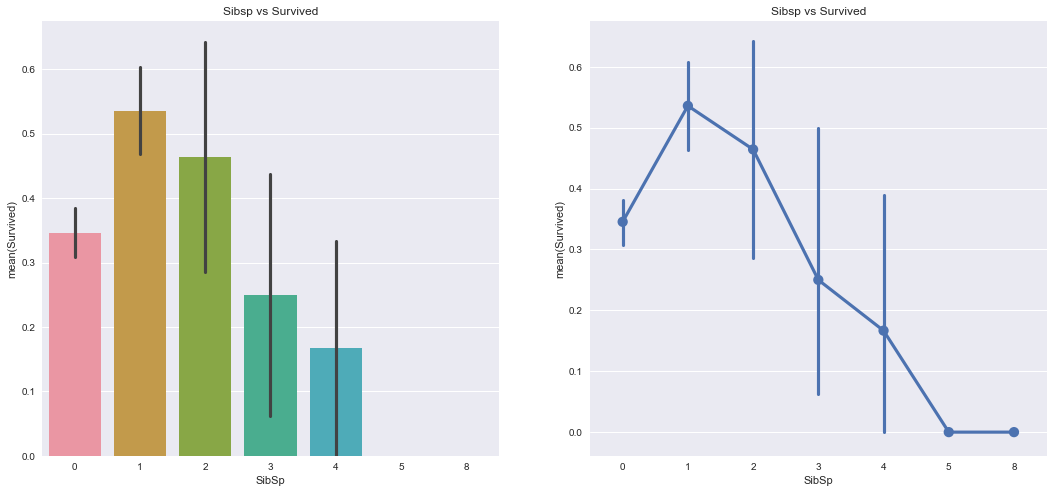

In [45]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.barplot('SibSp','Survived',data=X_plot,ax=ax[0])
ax[0].set_title('Sibsp vs Survived')
sns.factorplot('SibSp','Survived',data=X_plot,ax =ax[1])
ax[1].set_title('Sibsp vs Survived')
plt.close(2)
plt.show()

In [46]:
pd.crosstab(X_plot.SibSp,X_plot.Pclass,margins=True).style.background_gradient(cmap='summer_r')

### Categorical Feature: Parch

- Similar to Siblings, passengers who have one 1 parent have higher chance of surviving
- Higher than 3 parents reduces chance of surviving

In [27]:
pd.crosstab(X_plot.Parch,X_plot.Survived,margins=True).style.background_gradient(cmap='summer_r')

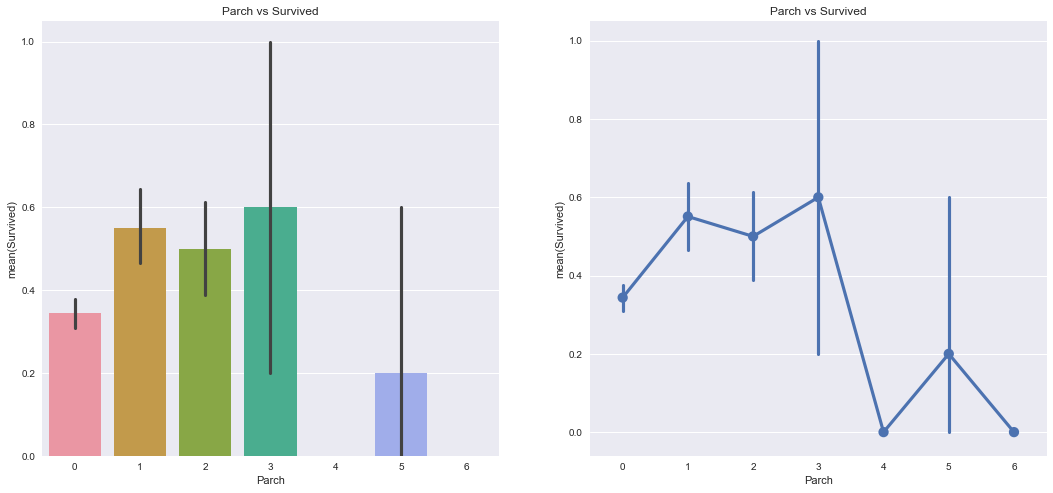

In [28]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.barplot('Parch','Survived',data=X_plot,ax=ax[0])
ax[0].set_title('Parch vs Survived')
sns.factorplot('Parch','Survived',data=X_plot,ax =ax[1])
ax[1].set_title('Parch vs Survived')
plt.close(2)
plt.show()

### Numerical Feature: Fare

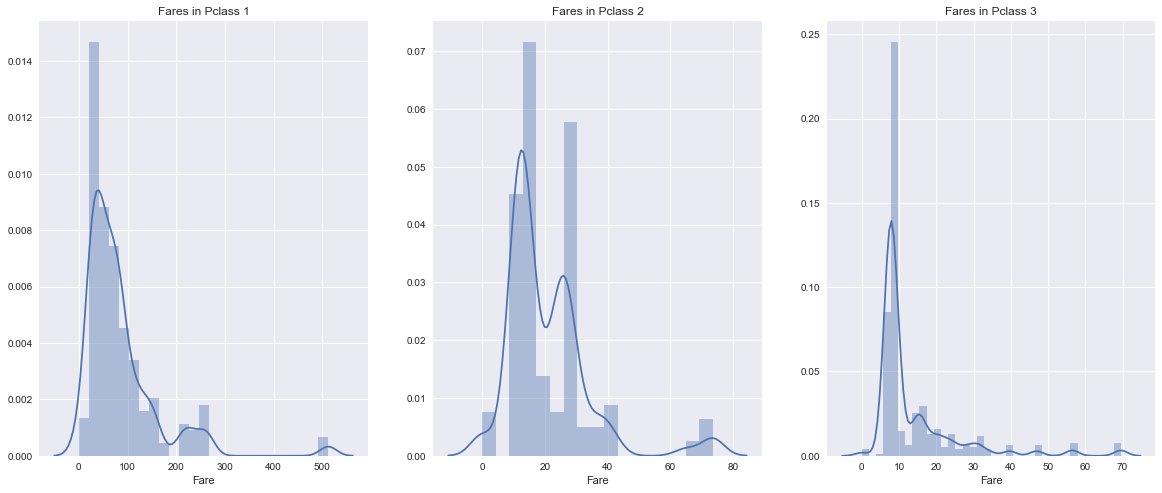

In [31]:
f,ax=plt.subplots(1,3,figsize=(20,8))
sns.distplot(X_plot[X_plot['Pclass']==1].Fare,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot(X_plot[X_plot['Pclass']==2].Fare,ax=ax[1])
ax[1].set_title('Fares in Pclass 2')
sns.distplot(X_plot[X_plot['Pclass']==3].Fare,ax=ax[2])
ax[2].set_title('Fares in Pclass 3')
plt.show()

### Correlation between Feature

- Most correlation between feature seems small
- Higest correlation of -0.55 between Fare and Pclass (kinda make sense)

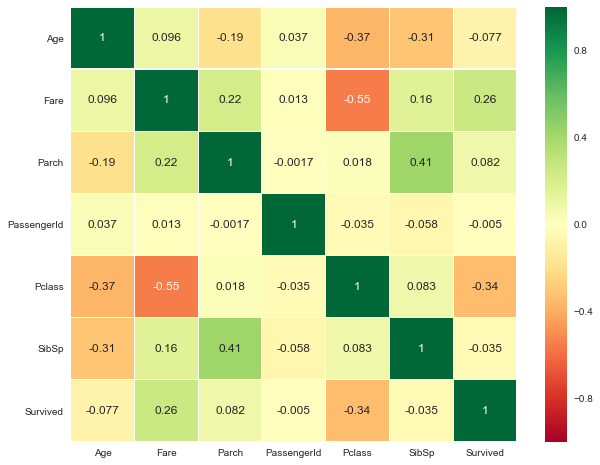

In [32]:
sns.heatmap(X_plot.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

### Pairplot
Make a pairplot for all numerical variables

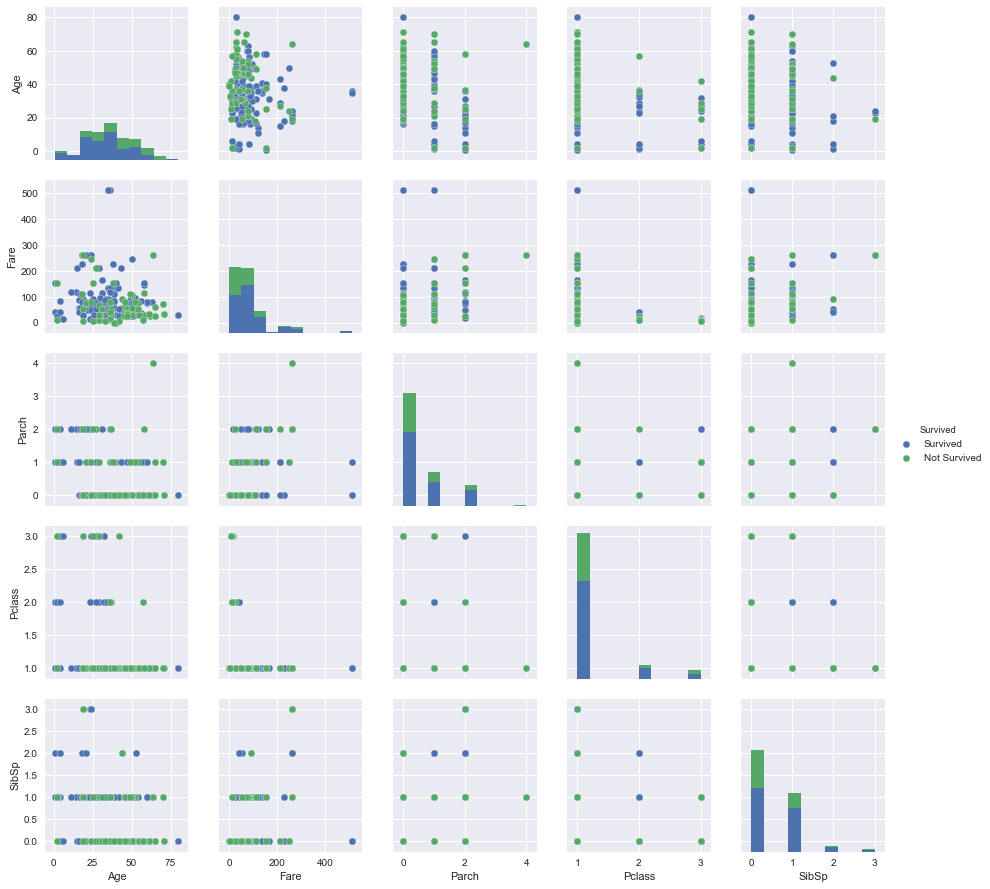

In [76]:
# Make new dataframe for pairplot purpose
X_pairplot = X.copy()
X_pairplot.loc[X_pairplot['Survived']==1,'Survived'] = 'Survived'
X_pairplot.loc[X_pairplot['Survived']==0,'Survived'] = 'Not Survived'

#X_pairplot[Survived=0] = 'Not Survived'

#Add Survived category to numerical attributes for plotting purpose
if 'Survived' not in num_attri:
    num_attri = num_attri + ['Survived']
    
g = sns.pairplot(X_pairplot,hue='Survived')

### Dummy Variables
For starter, create dummy variables for categorical features.

In [77]:
for column in (cat_attri):
    #Lets just keep every categorical attributes for plotting
    tempDF = pd.get_dummies(X[column],prefix=column)
    X.drop(column,axis=1,inplace=True)
    X = X.join(tempDF)

### Feature Evaluation
For starter using random forest to evaluate feature importance.
Code shamelessly brought from:http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [78]:
#Format dataframe for scikit training
y = X['Survived']
X.drop('Survived',axis=1,inplace=True)

Start with numerical feature ranking first

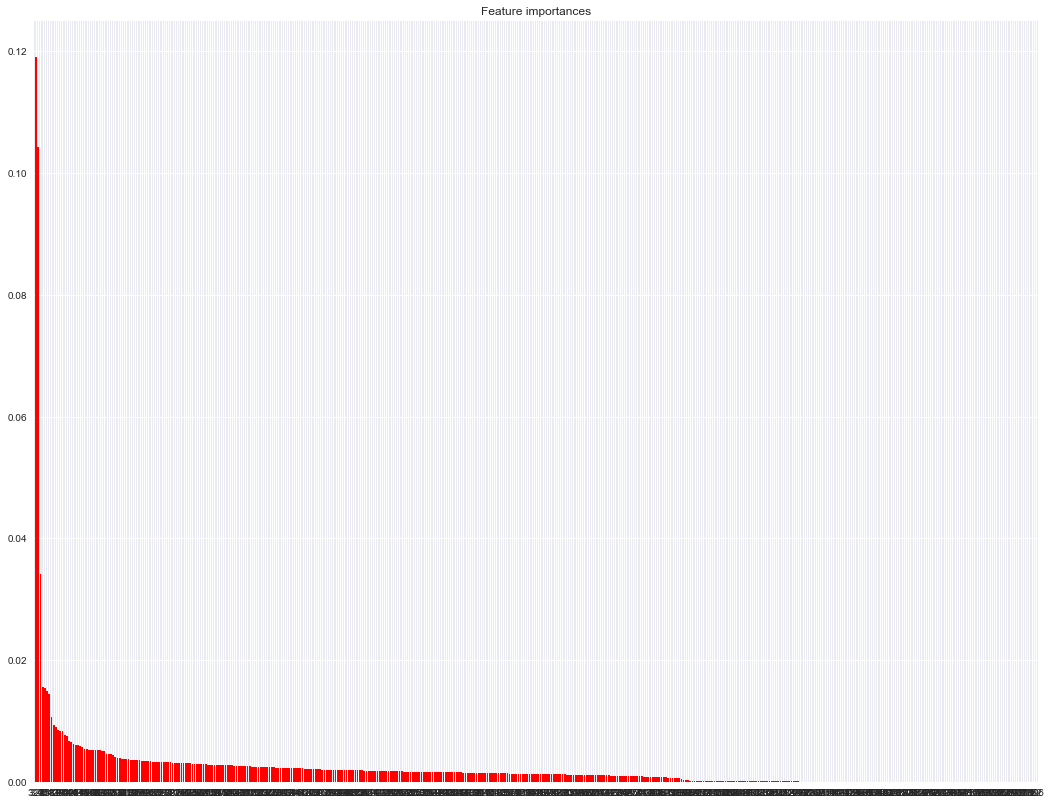

In [79]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features
#X, y = make_classification(n_samples=1000,
#                           n_features=10,
#                          n_informative=3,
#                           n_redundant=0,
#                           n_repeated=0,
#                           n_classes=2,
#                           random_state=0,
#                           shuffle=False)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
#print("Feature ranking:")

#for f in range(X.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(18,14))
plt.title("Feature importances")
#plt.bar(range(X.shape[1]), importances[indices],
#       color="r", yerr=std[indices], align="center")

plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")

plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

### Model Training
For the sake of early versions use all features for learning. Use 5 fold CV grid search (with 1 fold labelled test set and will not be the part of parameter tuning)

First split into 4:1 train/CV and test dataset

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

clf = xgb.XGBClassifier(
        nthread = 1,
        silent = 1,
        )
# specify parameters via map
parameters = {'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [5,6,7,8],
              'subsample': [0.2,0.4,0.6,0.8],
              'colsample_bytree': [0.6,0.7,0.8]}
xgb_model = xgb.XGBClassifier()
clf = GridSearchCV(xgb_model, parameters, n_jobs=1, 
                   cv=4, 
                   scoring='roc_auc',
                   verbose=2, refit=False)
clf.fit(X_train,y_train)
best_param_4CV = clf.best_params_

/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Fitting 4 folds for each of 48 candidates, totalling 192 fits
[CV] objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 
[CV]  objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 -   0.3s
[CV] objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 
[CV]  objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 -   0.1s
[CV] objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 -   0.2s
[CV] objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 
[CV]  objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 -   0.1s
[CV] objective=binary:logistic, subsample=0.4, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 
[CV]  objective=binary:logistic, subsample=0.4, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 -   0.2s
[CV] objective=binary:logistic, subsample=0.4, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 
[CV]  objective=binary:logistic, subsample=0.4, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 -   0.3s
[CV] objective=binary:logistic, subsample=0.4, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 
[CV]  objective=binary:logistic, subsample=0.4, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 -   0.2s
[CV] objective=binary:logistic, subsa

[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:   41.7s finished


Performance on the 4thCV fold

In [82]:
print('Best AUC score:'+str(clf.best_score_))
print('Best Param:' +str(clf.best_params_))

Best AUC score:0.832411789124
Best Param:{'objective': 'binary:logistic', 'subsample': 0.6, 'learning_rate': 0.05, 'colsample_bytree': 0.7, 'max_depth': 5}


Now check performance on accuracy basis.

In [83]:
clf2 = xgb.XGBClassifier(
        nthread = 1,
        silent = 1,
        colsample_bytree = best_param_4CV['colsample_bytree'],
        learning_rate = best_param_4CV['learning_rate'],
        max_depth =  best_param_4CV['max_depth'],
        objective = best_param_4CV['objective'],
        subsample = best_param_4CV['subsample']
        )
clf2.fit(X_train,y_train)
from sklearn.metrics import accuracy_score
print('Accuracy:'+str(accuracy_score(y_train,clf2.predict(X_train))))

Accuracy:0.917808219178


In [86]:
import pickle
# save the model to disk
filename = 'master.sav'
pickle.dump(clf2, open(filename, 'wb'))

Now check performance on the test set.

In [84]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
print('Test set AUC score:'+str(roc_auc_score(y_test,clf2.predict(X_test))))
print('Test set Accuracy:'+str(accuracy_score(y_test,clf2.predict(X_test))))

Test set AUC score:0.67701863354
Test set Accuracy:0.702702702703
